<h2>Creating Class-wise Unlearnable Examples</h2>

<h3>Prepare Data</h3>

In [5]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Prepare Dataset
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.CIFAR10(root='/data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.CIFAR10(root='/data1/mjli/Code/kerdeq/data/', train=False, download=True, transform=test_transform)

clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


<h3>Prepare Model</h3>

In [6]:
from models.ResNet import ResNet18

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)



<h3>Prepare Perturbation Generator Tool</h3>

In [7]:
import numpy as np
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


class PerturbationTool():
    def __init__(self, seed=0, epsilon=0.03137254901, num_steps=20, step_size=0.00784313725):
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.seed = seed
        np.random.seed(seed)

    def random_noise(self, noise_shape=[10, 3, 32, 32]):
        random_noise = torch.FloatTensor(*noise_shape).uniform_(-self.epsilon, self.epsilon).to(device)
        return random_noise

    def min_min_attack(self, images, labels, model, optimizer, criterion, random_noise=None, sample_wise=False):
        # 这里的输入是一个 batch 的图像和标签

        if random_noise is None:
            random_noise = torch.FloatTensor(*images.shape).uniform_(-self.epsilon, self.epsilon).to(device)

        perturb_img = Variable(images.data + random_noise, requires_grad=True)
        perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)
        eta = random_noise
        for _ in range(self.num_steps):
            opt = torch.optim.SGD([perturb_img], lr=1e-3)
            opt.zero_grad()
            model.zero_grad()
            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                if hasattr(model, 'classify'):
                    model.classify = True
                logits = model(perturb_img)
                loss = criterion(logits, labels)
            else:
                logits, loss = criterion(model, perturb_img, labels, optimizer)
            perturb_img.retain_grad()
            loss.backward()
            eta = self.step_size * perturb_img.grad.data.sign() * (-1)
            perturb_img = Variable(perturb_img.data + eta, requires_grad=True)
            eta = torch.clamp(perturb_img.data - images.data, -self.epsilon, self.epsilon)
            perturb_img = Variable(images.data + eta, requires_grad=True)
            perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)

        return perturb_img, eta # 返回的也应该是一个 batch 的图像和扰动
    

    
noise_generator = PerturbationTool(epsilon=16/255, num_steps=10, step_size=4/255)


### Test noise_generator
images= torch.randn([1,3,32,32]).cuda()
labels= torch.ones([1]).long().cuda()

# noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
#                                                           random_noise=torch.zeros_like(images).cuda())


<h3>Generate Class-wise Error-Minimizing Noise</h3>

In [ ]:
from tqdm import tqdm
import collections

### Final noise####
noise = torch.zeros([10, 3, 32, 32])

data_iter = iter(clean_train_loader)
condition = True
train_idx = 0

while condition:
    # optimize base model for 10 steps （train base models with 10 batches）
    base_model.train()
    for param in base_model.parameters():
        param.requires_grad = True
    for j in range(0, 10): # 10 steps
        train_idx += 1
        #############Optimization of base model on data with noise#################
        #####1. each iteration is a batch, you may use next(data_iter) to get images and labels for training
        #### Point 2
        try:
            (images, labels) = next(data_iter)
        except: # if the data is run out, reset the iterator
            train_idx = 0
            data_iter = iter(clean_train_loader)
            (images, labels) = next(data_iter)
        for i, (image, label) in enumerate(zip(images, labels)):
            # Update noise to images
            images[i] += noise[label]
            train_idx += 1
        images, labels = images.cuda(), labels.cuda()
        base_model.zero_grad()
        optimizer.zero_grad()
        logits = base_model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    # Perturbation over entire dataset
    idx = 0
    for param in base_model.parameters():
        param.requires_grad = False
    for i, (images, labels) in tqdm(enumerate(clean_train_loader), total=len(clean_train_loader)):
        # 针对一个 batch 处理
        batch_start_idx, batch_noise = idx, []
        tmp_idx = 0 # 是当前 batch 中的相对索引
        for i, _ in enumerate(images):
            # Update noise to images
            batch_noise.append(noise[labels[tmp_idx]]) # 使用相对索引查找 label，然后利用label查找对应的噪声
            idx += 1
            tmp_idx += 1
        batch_noise = torch.stack(batch_noise).cuda()
        
        # Update class-wise perturbation
        base_model.eval()
        images, labels = images.cuda(), labels.cuda()
        perturb_img, eta = noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
                                                          random_noise=batch_noise)
        
        ################# Update noise by perturb_img or eta ####################
        #### Point 2      
        class_perturbations = collections.defaultdict(list)
        for j in range(len(eta)):
            cls = labels[j].item()
            class_perturbations[cls].append(eta[j].detach().cpu())
        # if a class has new perturbations, update the noise, else keep the old one
        for cls in class_perturbations: 
            cls_perturb = torch.stack(class_perturbations[cls])
            current_avg = cls_perturb.mean(dim=0)
            noise[cls] = current_avg

        
    # Eval stop condition
    eval_idx, total, correct = 0, 0, 0
    for i, (images, labels) in enumerate(clean_train_loader):
        eval_idx = 0
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[labels[eval_idx]]
            eval_idx += 1
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = base_model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('Accuracy %.2f' % (acc*100))
    if acc > 0.9:
        condition=False    


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Accuracy 10.00


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Accuracy 14.74


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Accuracy 19.64


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Accuracy 42.29


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Accuracy 69.64


100%|██████████| 98/98 [01:21<00:00,  1.20it/s]


Accuracy 87.07


100%|██████████| 98/98 [01:22<00:00,  1.18it/s]


Accuracy 95.95


In [9]:
# Examine the noise
print(noise)

tensor([[[[ 0.0293,  0.0235,  0.0423,  ..., -0.0467, -0.0083,  0.0247],
          [ 0.0327,  0.0457,  0.0418,  ..., -0.0254,  0.0048,  0.0212],
          [ 0.0398,  0.0418,  0.0410,  ..., -0.0304, -0.0096,  0.0189],
          ...,
          [-0.0494, -0.0459, -0.0448,  ..., -0.0385, -0.0164, -0.0063],
          [-0.0450, -0.0447, -0.0401,  ..., -0.0389, -0.0315, -0.0208],
          [-0.0454, -0.0428, -0.0394,  ..., -0.0403, -0.0372, -0.0319]],

         [[-0.0530, -0.0493, -0.0529,  ...,  0.0217,  0.0037, -0.0310],
          [-0.0529, -0.0522, -0.0522,  ...,  0.0221, -0.0129, -0.0316],
          [-0.0517, -0.0501, -0.0477,  ...,  0.0124, -0.0066, -0.0349],
          ...,
          [ 0.0456,  0.0463,  0.0422,  ...,  0.0215, -0.0005, -0.0132],
          [ 0.0400,  0.0427,  0.0352,  ...,  0.0268,  0.0223,  0.0075],
          [ 0.0384,  0.0400,  0.0314,  ...,  0.0285,  0.0157,  0.0162]],

         [[-0.0524,  0.0437,  0.0404,  ...,  0.0181, -0.0228,  0.0052],
          [-0.0609,  0.0366,  

<h3>Create Unlearnable class-wise min-min Dataset</h3>

In [11]:
import numpy as np

# Add standard augmentation
train_transform = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
clean_train_dataset = datasets.CIFAR10(root='/data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)
unlearnable_train_dataset = datasets.CIFAR10(root='/data1/mjli/Code/kerdeq/data/', train=True, download=True, transform=train_transform)

##########Add the generated noise to the clean dataset to generate the unlearnable dataset###########
##########Point 2, you can refer to such part in samplewise.ipynb


perturb_noise = noise.mul(255).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu').numpy()
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.float32)

for i in range(len(unlearnable_train_dataset)):
    label = unlearnable_train_dataset.targets[i]
    unlearnable_train_dataset.data[i] += perturb_noise[label]
    unlearnable_train_dataset.data[i] = np.clip(unlearnable_train_dataset.data[i], a_min=0, a_max=255)
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.uint8)




Files already downloaded and verified
Files already downloaded and verified


<h3>Visualize Clean Images, Error-Minimizing Noise, Unlearnable Images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


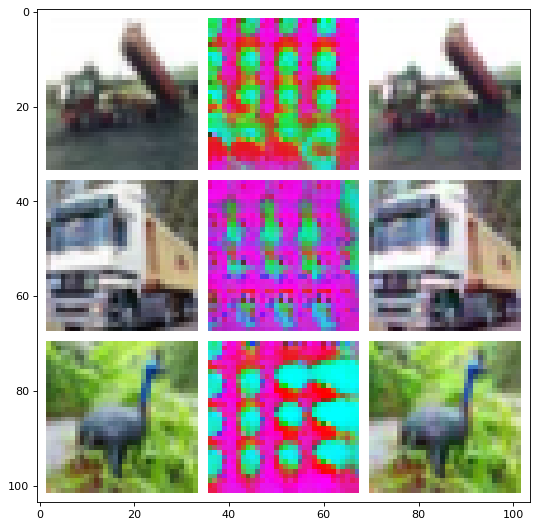

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def imshow(img):
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_pairs_of_imgs(idx):
    clean_img = clean_train_dataset.data[idx]
    unlearnable_img = unlearnable_train_dataset.data[idx]
    clean_img = torchvision.transforms.functional.to_tensor(clean_img)
    unlearnable_img = torchvision.transforms.functional.to_tensor(unlearnable_img)

    label = clean_train_dataset.targets[idx]
    x = noise[label]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    return [clean_img, noise_norm, unlearnable_img]
    
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    

imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))



<h3>Train ResNet18 on Unlearnable Dataset</h3>

In [14]:
from util import AverageMeter

model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=unlearnable_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
            

Acc 53.26 Loss: 1.29: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]


Clean Accuracy 18.01



Acc 94.50 Loss: 0.17: 100%|██████████| 391/391 [00:45<00:00,  8.66it/s]


Clean Accuracy 13.39



Acc 98.46 Loss: 0.05: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]


Clean Accuracy 10.94



Acc 98.97 Loss: 0.03: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]


Clean Accuracy 11.30



Acc 99.25 Loss: 0.02: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]


Clean Accuracy 9.91



Acc 99.25 Loss: 0.02: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]


Clean Accuracy 10.01



Acc 99.49 Loss: 0.02: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]


Clean Accuracy 10.08



Acc 99.42 Loss: 0.02: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]


Clean Accuracy 10.68



Acc 99.61 Loss: 0.01: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


Clean Accuracy 10.38



Acc 99.53 Loss: 0.02: 100%|██████████| 391/391 [00:44<00:00,  8.76it/s]


Clean Accuracy 10.26



Acc 99.59 Loss: 0.01: 100%|██████████| 391/391 [00:42<00:00,  9.12it/s]


Clean Accuracy 10.82



Acc 99.67 Loss: 0.01: 100%|██████████| 391/391 [00:44<00:00,  8.81it/s]


Clean Accuracy 10.03



Acc 99.72 Loss: 0.01: 100%|██████████| 391/391 [00:45<00:00,  8.68it/s]


Clean Accuracy 11.17



Acc 99.68 Loss: 0.01: 100%|██████████| 391/391 [00:44<00:00,  8.71it/s]


Clean Accuracy 10.12



Acc 99.73 Loss: 0.01: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]


Clean Accuracy 11.67



Acc 99.85 Loss: 0.01: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]


Clean Accuracy 10.28



Acc 99.93 Loss: 0.00: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]


Clean Accuracy 10.45



Acc 99.88 Loss: 0.01: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]


Clean Accuracy 10.74



Acc 99.85 Loss: 0.01: 100%|██████████| 391/391 [00:45<00:00,  8.68it/s]


Clean Accuracy 9.85



Acc 99.88 Loss: 0.01: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]


Clean Accuracy 10.10



Acc 99.94 Loss: 0.00: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]


Clean Accuracy 10.41



Acc 99.96 Loss: 0.00: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]


Clean Accuracy 10.16



Acc 99.98 Loss: 0.00: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s]


Clean Accuracy 9.76



Acc 99.99 Loss: 0.00: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]


Clean Accuracy 10.09



Acc 99.99 Loss: 0.00: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]


Clean Accuracy 9.95



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s]


Clean Accuracy 10.19



Acc 99.99 Loss: 0.00: 100%|██████████| 391/391 [00:44<00:00,  8.70it/s] 


Clean Accuracy 10.14



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]


Clean Accuracy 10.08



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:44<00:00,  8.83it/s]


Clean Accuracy 10.06



Acc 100.00 Loss: 0.00: 100%|██████████| 391/391 [00:44<00:00,  8.71it/s]


Clean Accuracy 9.93

